In [1]:
%matplotlib widget

from tvb.simulator.lab import *
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

import matplotlib.pyplot as plt
import numpy as np
import time as tm

# The normal form of a supercritical Hopf bifurcation
***

The **SupHopf** model corresponds to the **normal form of a supercritical Hopf bifurcation** that describes the transition from a stable to unstable focus giving birth to a stable limit cycle. Thus, in Cartesian coordinates, the system is described by the following equation:

\begin{eqnarray}
    \dot{x} &=& (a - x^{2} - y^{2})x - \omega y \\
    \dot{y} &=& (a - x^{2} - y^{2})y + \omega x
\end{eqnarray}

where $a$ is the bifurcation parameter and $\omega$ is the angular frequency of the oscillator.

This normal form has a **supercritical bifurcation at** $\mathbf{a=0}$ (critical point in figure below), so that if $a > 0$ the system engages in a stable limit cycle with frequency $f = \omega / 2\pi$ (orange area in figure below), and for $a < 0$ the system returns to a stable focus (green area in figure below).

This model has been applied and published in **Deco et al. (Sci Report, 2017a)**.

# 1. Exploring the SupHopf model

Before launching any simulations, we will have a look at the phase space of the model in order to better understand its dynamics. We will use the phase plane interactive tool.

We plot the two nullclines that are defined as zero flux in either the $x$ or $y$ direction: the cubic nullclines in red and green. The intersections of the nullclines identify the fixed points of the system. 

Have a look to the phase space for the 2D system:

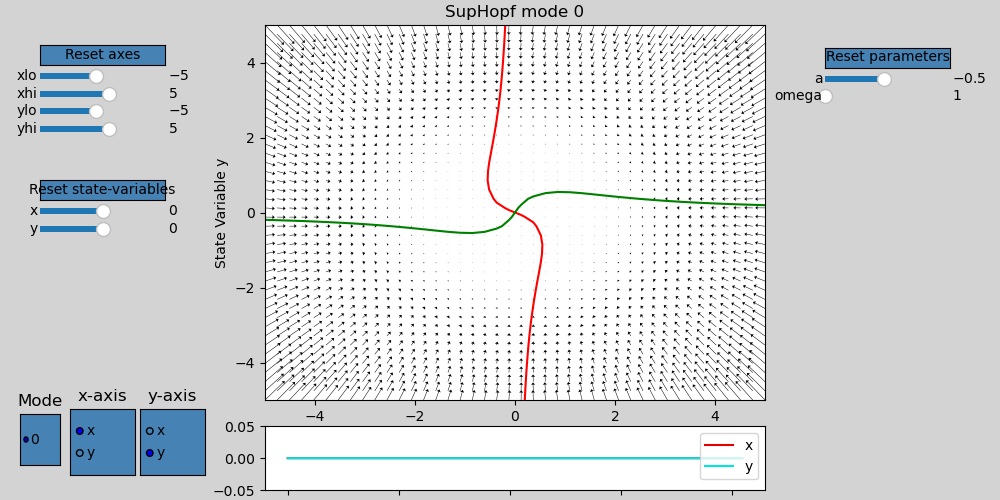

In [2]:
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

# Create a supHopf model instance.
Hopf = models.oscillator.SupHopf()

# Initialise a (stochastic) Integrator scheme.
dt = 0.1  #integration steps [ms]
heundetint = integrators.HeunDeterministic(dt=dt)
#heunstochint = integrators.HeunStochastic(dt=dt)
#heunstochint.noise.nsig = 0.01                      #standard deviation of the noise 

# Open the phase plane tool with the Epileptor model and (stochastic) Integrator.
ppi_fig = PhasePlaneInteractive(model=Hopf, integrator=heundetint)
ppi_fig.show()

# 2. Simulation with the SupHopf model

## Setting up the simulation

Note that the parameters used in this tutorial are taken from Deco et al. (Sci Report, 2017a).

- ### Connectivity

We start by loading and visualizing the structural connectivity matrix that represents the set of all existing anatomical connections between brain areas. Having loaded the dataset with 68 brain regions in the Desikan-Killany parcellation, we can then alter the speed of signal propagation through the network.

WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


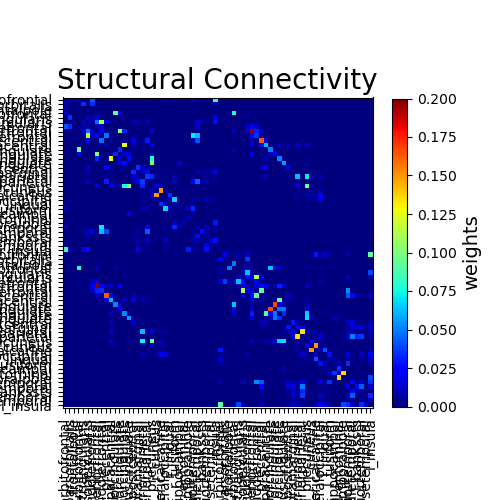

In [3]:
# Initialise the Connectivity.
con = connectivity.Connectivity.from_file('connectivity_68.zip')      
nregions = len(con.region_labels)                               #number of regions
con.weights = con.weights - con.weights * np.eye((nregions))    #remove self-connections
con.weights = 0.2 * con.weights / np.abs(con.weights.max())     #scaled to a maximum value of 0.2
con.speed = np.array([sys.float_info.max])                      #set conduction speed (here we neglect it)
con.configure()

# Visualization.
plt.figure(figsize=(5,5))
plt.imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
plt.title('Structural Connectivity', fontsize=20)
plt.xticks(range(0, nregions), con.region_labels, fontsize=10, rotation=90)
plt.yticks(range(0, nregions), con.region_labels, fontsize=10)
cb=plt.colorbar(shrink=0.8)
cb.set_label('weights', fontsize=14)
plt.show()

- ### Model

The **local neural (or Model)** dynamics of each brain area is a set of differential equations. There are a number of predefined models available in TVB. For our purpose here we will use the **SupHopf** that we defined above.

In [4]:
# Initialise the Model.
mod = models.SupHopf()
mod.a = np.ones((nregions)) * (0)             #critical bifurcation point
mod.omega = np.ones((nregions)) * (2*np.pi*0.05) #omega= 2*pi*f

Note that due to the mesoscopic nature of the ultra-slow Hopf model considered herein (intrinsic frequency sets at 0.05 Hz) - which explicitly neglects the contribution of faster neurophysiological rhythms - the variable $x$ directly emulates the ultra-slow dynamics of the BOLD signal at each node, without the need to apply an hemodynamic response function, which is necessary in more detailed models of neuronal activity.

- ### Coupling function

It is a function that is used to join the local Model dynamics at distinct spatial locations over the connections described in Connectivity. Proper setting of the parameters for this function requires some knowledge of the properties of both the model being used and the structure through which it is connected. For our present purpose, we will use the **Difference coupling class** connected through the connectivity matrix.

\begin{eqnarray}
    \dot{x}_{i} &=& (a - x_{i}^{2} - y_{i}^{2})x_{i} - \omega y_{i} + G \sum_{j}C_{ij}(x_{j} - x_{i})\\
    \dot{y}_{i} &=& (a - x_{i}^{2} - y_{i}^{2})y_{i} + \omega x_{i} + G \sum_{j}C_{ij}(y_{j} - y_{i})
\end{eqnarray}

where $G$ is the global scaling factor (global conductivity parameter scaling equally all synaptic connections), and $C_{ij}$ denotes the density of fibres between cortical area $i$ and $j$ as extracted from the DTI based tractography (scaled to a maximum value of 0.2). 

In [5]:
# Initialise a Coupling function.
coupl = 2.85  #coupling strength: G in equation above
con_coupling = coupling.Difference(a=np.array([coupl]))

- ### Integrator.

Now that we have defined our structure and dynamics, we need to select an integration scheme. While TVB supports a number of schemes, for most purposes you should use either **HeunDeterministic** or **HeunStochastic**.

\begin{eqnarray}
    \dot{x}_{i} &=& (a - x_{i}^{2} - y_{i}^{2})x_{i} - \omega y_{i} + G \sum_{j}C_{ij}(x_{j} - x_{i}) + \beta\eta_{i}(t)\\
    \dot{y}_{i} &=& (a - x_{i}^{2} - y_{i}^{2})y_{i} + \omega x_{i} + G \sum_{j}C_{ij}(y_{j} - y_{i}) + \beta\eta_{i}(t)
\end{eqnarray}

where $\eta_{i}(t)$ is additive Gaussian noise with standard deviation $\beta=0.02$. 

Note that the most important thing here is to use a step size that is small enough for the integration to be numerically stable.

In [6]:
dt = 0.01          #integration steps [ms]
sigma = 0.02       #standard deviation of the noise

nsigma = 2*np.sqrt(np.square(sigma)/2)
hiss = noise.Additive(nsig=np.array([nsigma, nsigma]))
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

- ### Monitors

The last components we need to define are some **Monitors**. Although there are Monitors which apply a biophysical measurement process to the simulated neural activity, such as EEG, MEG, etc, here we will select one simple monitor just to show the idea:

- **TemporalAverage** monitor averages over a time window of length period returning one time point every period ms.

In [7]:
# Initialise some Monitors with period in physical time.
mon_tavg = monitors.TemporalAverage(period=1940) #TR of the empirical fMRI BOLD signal  

***

## Simulate

The last step is to bring all these components together into a **Simulator object**. We then need to run the configure method, which basically just acts to calculate information necessary for the simulation that draws on specific combinations of the components.

In [8]:
# Initialise the Simulator.
sim = simulator.Simulator(model=mod,
                          connectivity=con,
                          conduction_speed=np.float64(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=[(mon_tavg)])
sim.configure()

,value
Type,Simulator
conduction_speed,1.7976931348623157e+308
connectivity,Connectivity gid: ae99c731-6e0b-422c-971b-b70f053e7194
coupling,Difference gid: 69d2db5a-f510-48c2-a0ea-573b232b8871
gid,UUID('60ab25be-5eed-4db8-aa1c-19b01e9c9b59')
initial_conditions,None
integrator,HeunStochastic gid: 2301c0e8-5b76-4a1b-9d09-a9bd6f16998f
model,SupHopf gid: ab231470-bc14-4028-a5ba-b5c0e684d021
monitors,[]
simulation_length,1000.0


Now, we can run the simulation. The simulator that we have created is an iterable object, so all we need to do is iterate for some length, which we provide in ms, and collect the output:

In [9]:
# Perform simulation.
print("Starting simulation...")
tic = tm.time()
(t, y), = sim.run(simulation_length=20000)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for 478.6068136692047


***

## Visualize our simulation

And finally, we can have a look at the results of our simulation in terms of time series.
The data returned by the simulator are in the form of a list of arrays.

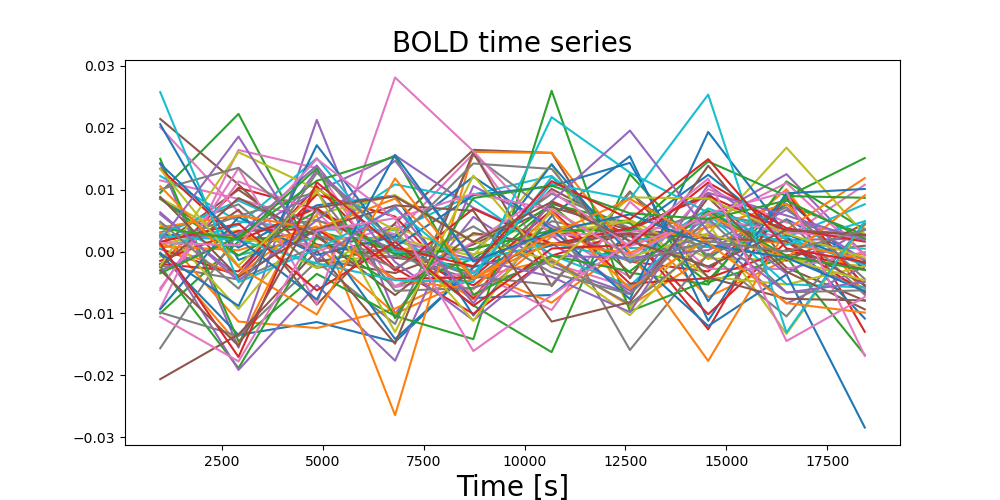

In [10]:
# Plot time series.
plt.figure(figsize=(10,5))
plt.plot(t[:], y[:, 0, :, 0])
plt.title('BOLD time series', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.show()